In [52]:
import pandas as pd
import glob
import json

# Load all eval jsons matching a pattern
import re

def extract_model_persona_from_fname(fname):
    # e.g. asteroids_a2c_asteroids_hunter_novice_eval.json
    # pattern for model: after first '_' and before next '_'
    # pattern for persona: after model and next '_', or the next
    parts = fname.lower().split('_')
    model = None
    persona = None
    for i, p in enumerate(parts):
        if p in ('a2c', 'ppo'):
            model = p
            if i+2 < len(parts):
                persona = parts[i+2]
            break
    return model, persona

all_rows = []
for fname in glob.glob('../models/*.json'):
    model, persona = extract_model_persona_from_fname(fname)
    with open(fname) as f:
        data = json.load(f)
        if isinstance(data, list):
            for row in data:
                row['file'] = fname
                row['model'] = model
                row['persona'] = persona
                all_rows.append(row)
        elif isinstance(data, dict):
            num_eps = len(data['scores'])
            for i in range(num_eps):
                row = {'file': fname, 'model': model, 'persona': persona}
                for key in data:
                    if isinstance(data[key], list):
                        row[key] = data[key][i]
                    else:
                        row[key] = data[key]
                all_rows.append(row)

all_df = pd.DataFrame(all_rows)



In [ ]:
import numpy as np

def extract_scalar(val):
    if isinstance(val, (list, np.ndarray)) and len(val) == 1:
        return val[0]
    elif isinstance(val, (list, np.ndarray)):
        # Take the first element, or handle as needed
        return val[0]
    else:
        return val

all_df['episode_rewards'] = all_df['episode_rewards'].apply(extract_scalar).astype(float)
all_df['scores'] = all_df['scores'].apply(extract_scalar).astype(float)


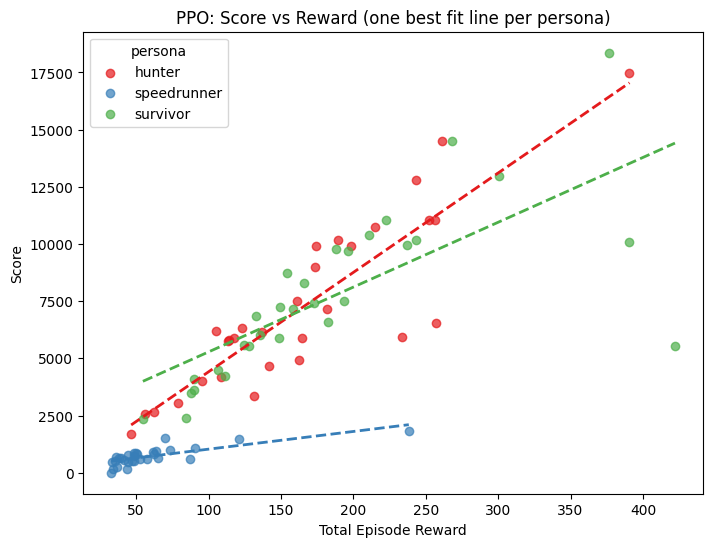

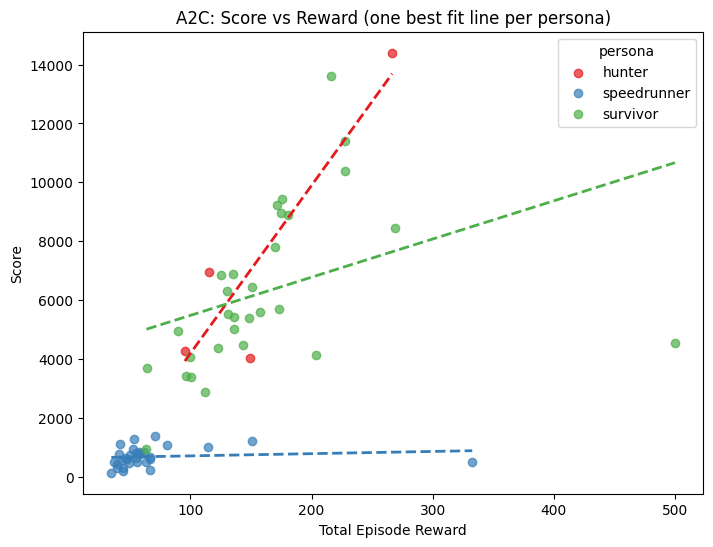

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Define a color palette for personas
persona_palette = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00',
    '#a65628', '#f781bf', '#999999', '#dede00', '#000000'
]
persona_list = list(all_df['persona'].unique())
persona_color_map = {persona: persona_palette[i % len(persona_palette)] for i, persona in enumerate(persona_list)}

# -- 1. PPO only: color by persona, best fit per persona --
plt.figure(figsize=(8,6))
df = all_df[all_df['model'] == 'ppo']
for persona in df['persona'].unique():
    mask = (df['persona'] == persona)
    x = df.loc[mask, 'episode_rewards']
    y = df.loc[mask, 'scores']
    plt.scatter(
        x, y,
        color=persona_color_map[persona],
        marker='o',
        label=persona,
        alpha=0.7
    )
    if len(x) > 1:
        m, b = np.polyfit(x, y, 1)
        plt.plot(
            np.sort(x),
            m * np.sort(x) + b,
            color=persona_color_map[persona],
            linestyle='--',
            linewidth=2
        )
plt.legend(title='persona')
plt.title('PPO: Score vs Reward (one best fit line per persona)')
plt.xlabel('Total Episode Reward')
plt.ylabel('Score')
plt.show()

# -- 2. A2C only: color by persona, best fit per persona --
plt.figure(figsize=(8,6))
df = all_df[all_df['model'] == 'a2c']
for persona in df['persona'].unique():
    mask = (df['persona'] == persona)
    x = df.loc[mask, 'episode_rewards']
    y = df.loc[mask, 'scores']
    plt.scatter(
        x, y,
        color=persona_color_map[persona],
        marker='o',
        label=persona,
        alpha=0.7
    )
    if len(x) > 1:
        m, b = np.polyfit(x, y, 1)
        plt.plot(
            np.sort(x),
            m * np.sort(x) + b,
            color=persona_color_map[persona],
            linestyle='--',
            linewidth=2
        )
plt.legend(title='persona')
plt.title('A2C: Score vs Reward (one best fit line per persona)')
plt.xlabel('Total Episode Reward')
plt.ylabel('Score')
plt.show()


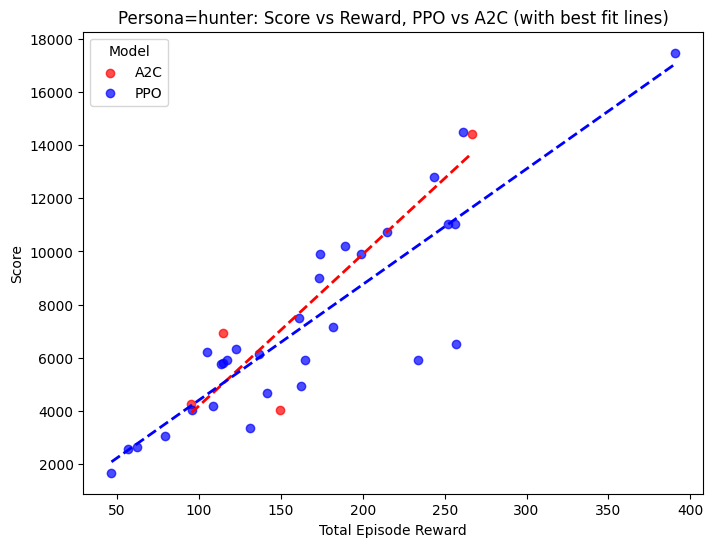

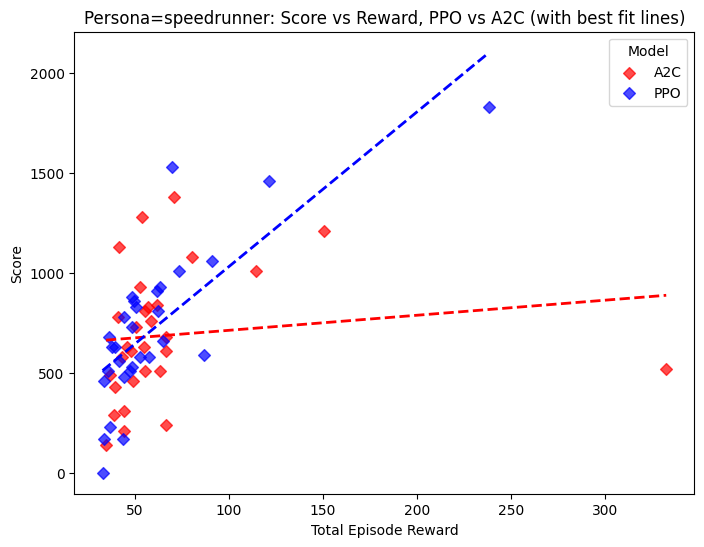

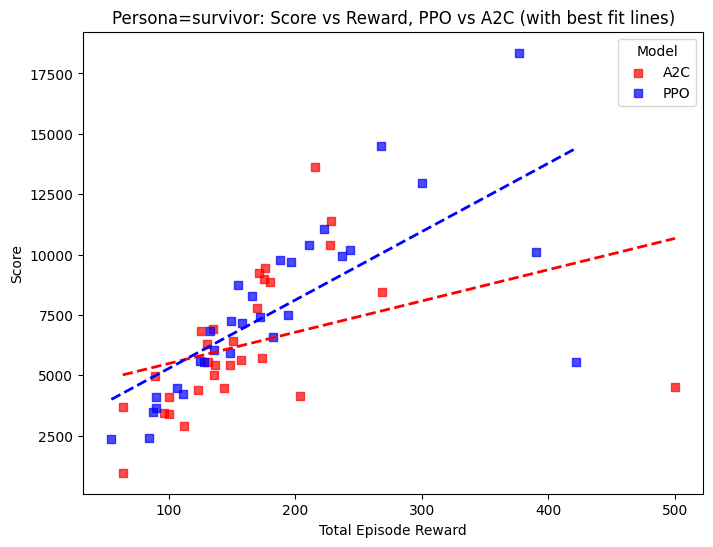

In [55]:
import numpy as np
import matplotlib.pyplot as plt

model_colors = {'a2c': 'red', 'ppo': 'blue'}
persona_markers = {
    'hunter': 'o',
    'survivor': 's',
    'baseline': '^',
    'speedrunner': 'D',
    'simple': 'v'
}

for persona in all_df['persona'].unique():
    plt.figure(figsize=(8,6))
    df = all_df[all_df['persona'] == persona]
    for model in df['model'].unique():
        mask = (df['model'] == model)
        x = df.loc[mask, 'episode_rewards']
        y = df.loc[mask, 'scores']
        plt.scatter(
            x, y,
            color=model_colors.get(model, 'gray'),
            marker=persona_markers.get(persona, 'o'),
            label=model.upper(),
            alpha=0.7
        )
        # line of best fit for this model
        if len(x) > 1:
            m, b = np.polyfit(x, y, 1)
            plt.plot(
                np.sort(x),
                m * np.sort(x) + b,
                color=model_colors.get(model, 'gray'),
                linestyle='--',
                linewidth=2
            )
    plt.legend(title='Model')
    plt.title(f'Persona={persona}: Score vs Reward, PPO vs A2C (with best fit lines)')
    plt.xlabel('Total Episode Reward')
    plt.ylabel('Score')
    plt.show()
